* This notebook is to investigate why mixing region sho up in the near field and north of the river mouth at low tides rather than high tides.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import pytz
import R_mixStuff as RS
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{'lat': 49.0419, 'lon': -123.3176,'depth': 170, 'j': 36, 'i': 43},    
    'VENUS Central':{ 'lat': 49.0401,'lon': -123.4261, 'depth': 300, 'j': 44, 'i': 26 },
    'Point on transect':{'j':36,'i':20},
    'mouth':{ 'j':38,'i':73},
    'near field':{'j':43,'i':64},
    'middle':{'j':40,'i':70},
    'estuary':{'j':36,'i':102},
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load all simulation results

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc')
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [5]:
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

# Tidal heights

In [6]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [7]:
def find_ind_tide(run_low, run_up, run_label1,run_label2):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label1 = run_label1.replace(tzinfo=pytz.utc)
    run_label2 = run_label2.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label1:
            lab_ind1 = i  
        if ttide_dt[i]== run_label2:
            lab_ind2 = i  
    return low_ind, up_ind, lab_ind1,lab_ind2

In [8]:
## select the time slot to make comparison
strings = {'specific time': {'t_ind_high': -4,'t_ind_low':-12,'middle of flood':-8},
              'ave':{'t_ind_high':-1,'t_ind_low':-1},
           'current specific':{'t_ind_high': -4,'t_ind_low':-7,'middle of flood':-5}}

In [9]:
## define dates
sd = datetime.datetime(2014,10,1,0,30,tzinfo=pytz.utc)
ed = datetime.datetime(2014,10,31,23,30,tzinfo=pytz.utc)

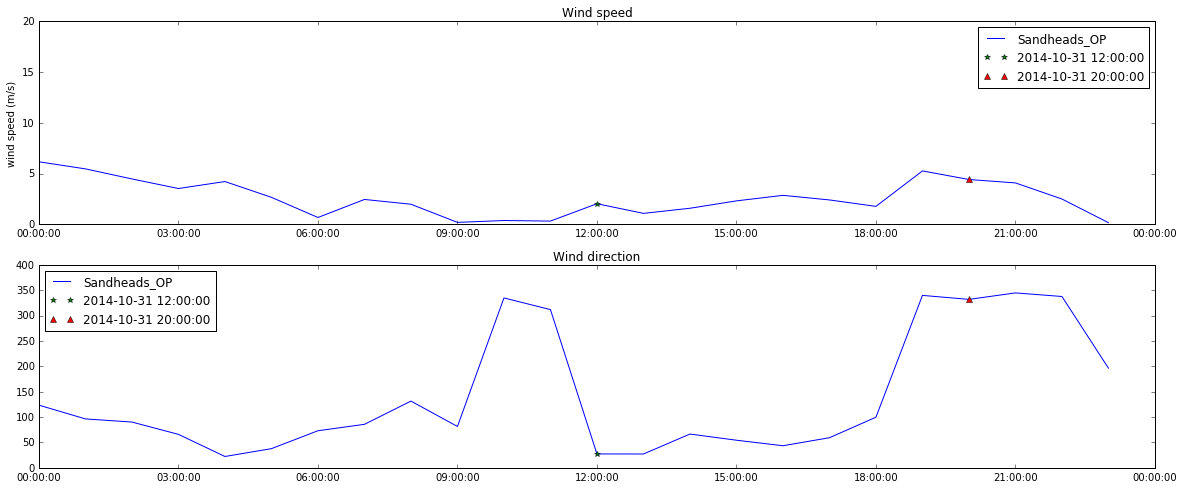

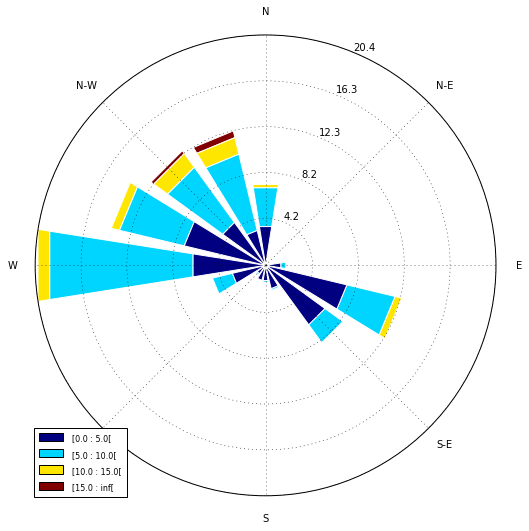

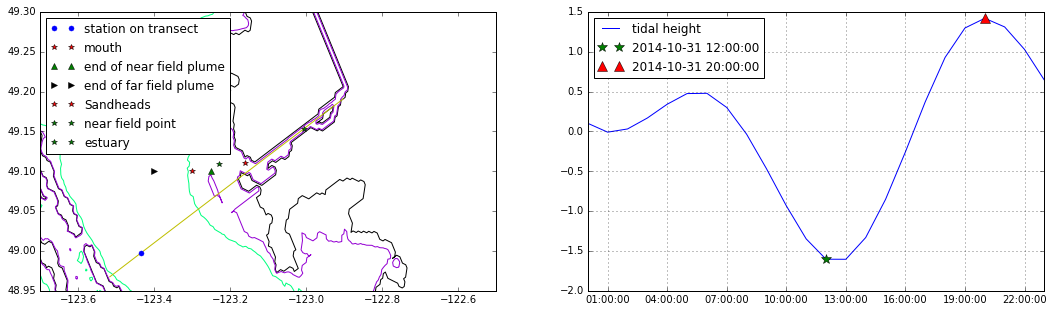

In [10]:
fig, axs = plt.subplots(1,2,figsize = (18,5))
ax = axs[0]
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 50,color = 'springgreen')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'y-') ## transect
ax.plot(lon[36,20],lat[36,20],'b.',markersize = 10,label ='station on transect')
ax.plot(-123.16, 49.11,'r*',label = 'mouth') ## (39,74)
ax.plot(-123.25, 49.1,'g^',label = 'end of near field plume') ## (43,59)
ax.plot(-123.4, 49.1,'k>',label = 'end of far field plume') ## (33,38)
ax.plot(-123.3,49.1,'r*',label = 'Sandheads')
ax.plot(lon[43,64],lat[43,64],'g*',label = 'near field point') ## (43,64)
ax.plot(lon[36,102],lat[36,102],'g*',label = 'estuary') ## (36,102)
ax.set_xlim([-123.7,-122.5])
ax.set_ylim([48.95,49.3])
ax.legend(loc  = 'best')
ax = axs[1]
run_low = datetime.datetime(2014,10,31)
run_up = datetime.datetime(2014,11,1)
run_label1 = datetime.datetime(2014,10,31,12)
run_label2 = datetime.datetime(2014,10,31,20)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind],label = 'tidal height')
ax.plot(ttide.time[lab_ind1],ttide.pred_all[lab_ind1],'g*',markersize = 10,label = run_label1)
ax.plot(ttide.time[lab_ind2],ttide.pred_all[lab_ind2],'r^',markersize = 10,label = run_label2)
ax.legend(loc = 'best')
ax.grid('on')
X =Image(filename='/ocean/jieliu/research/meopar/surface current/wind_31oct14.png')
Y =Image(filename='/ocean/jieliu/research/meopar/surface current/windrose.png')
display(X,Y)

# R_mix plot

# No wind case

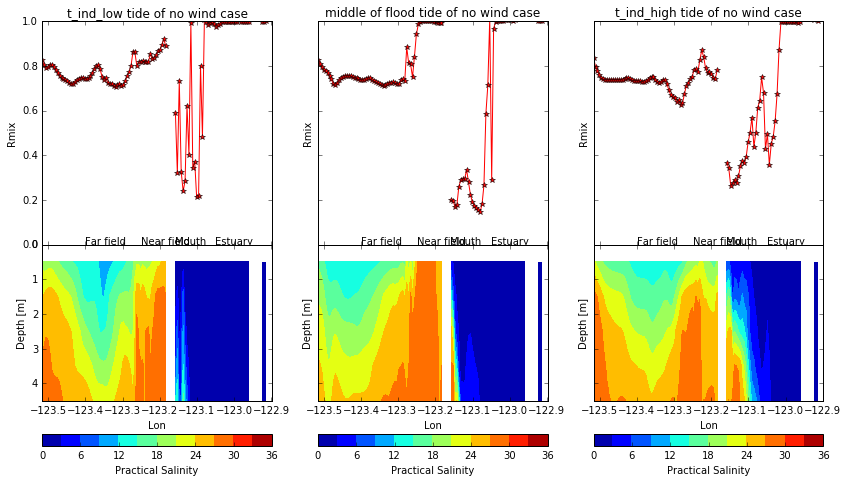

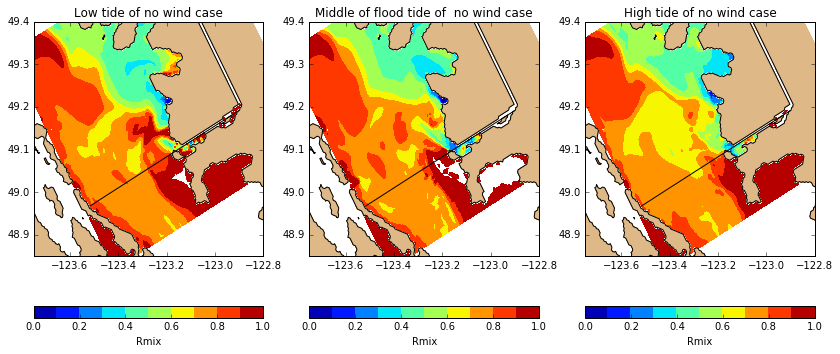

In [21]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case')

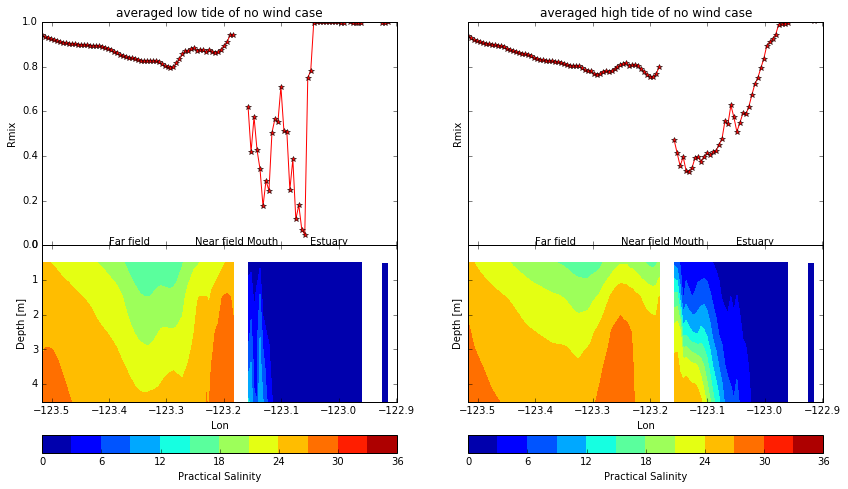

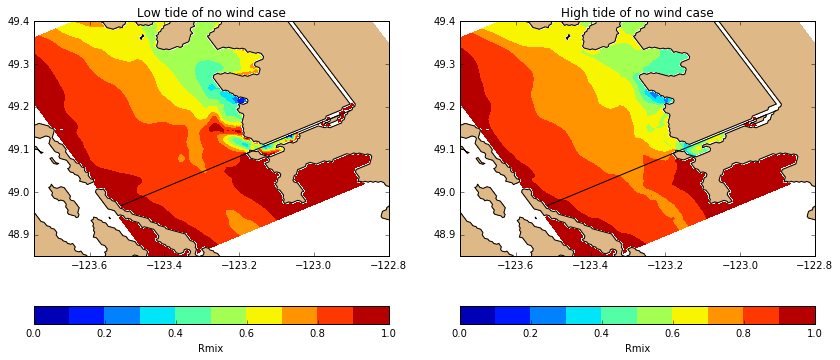

In [10]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case',string = 'ave')

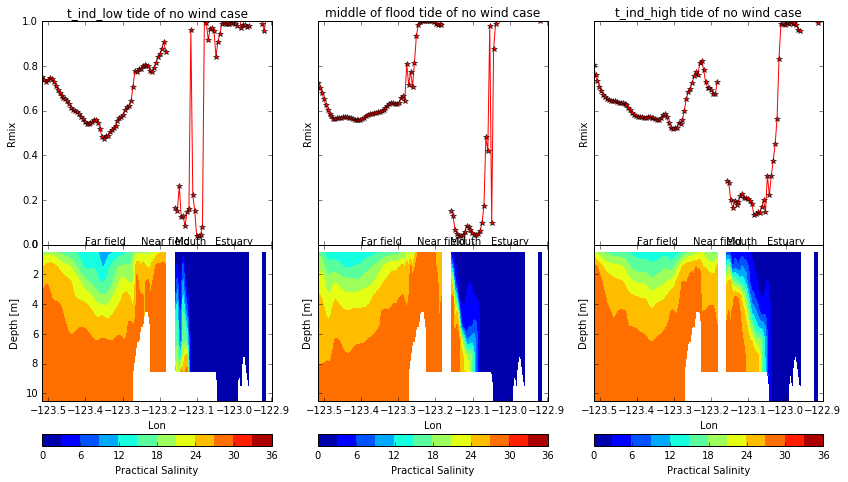

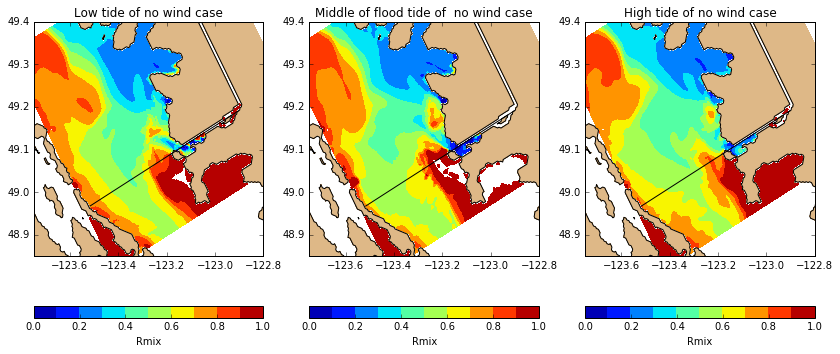

In [23]:
fig = RS.plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case')

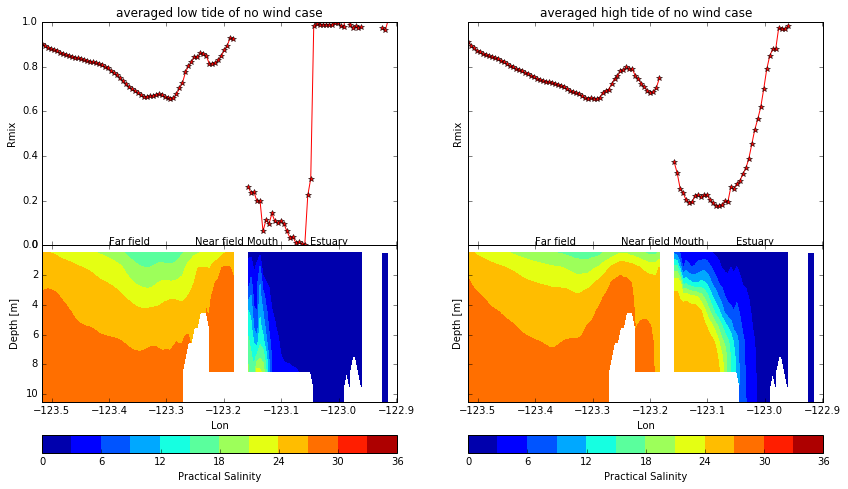

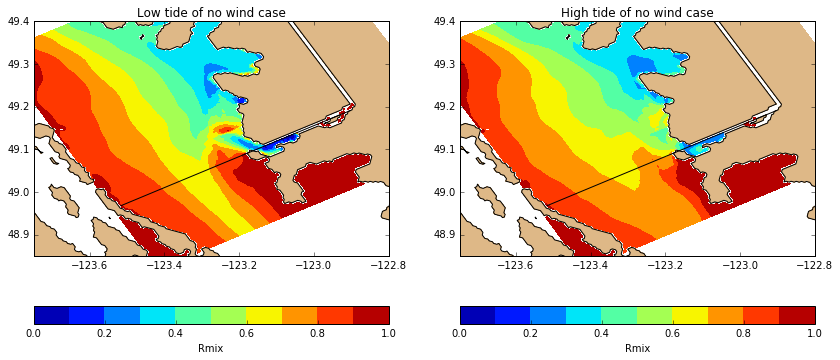

In [11]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case',string = 'ave')

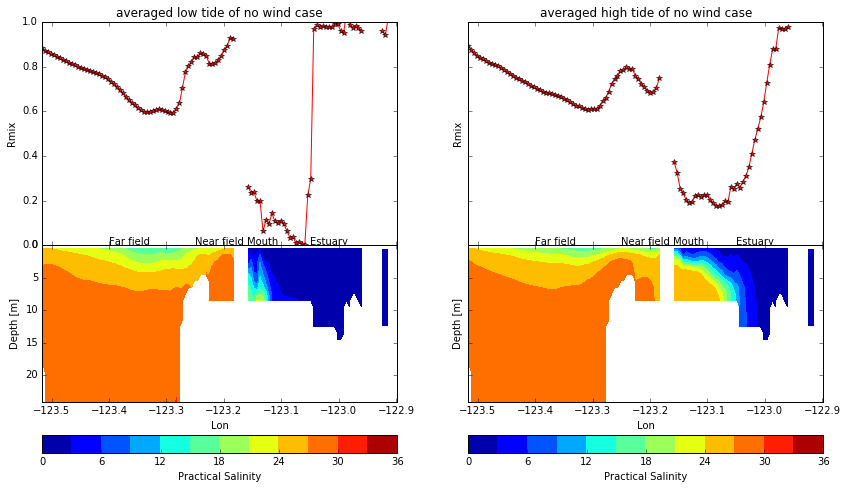

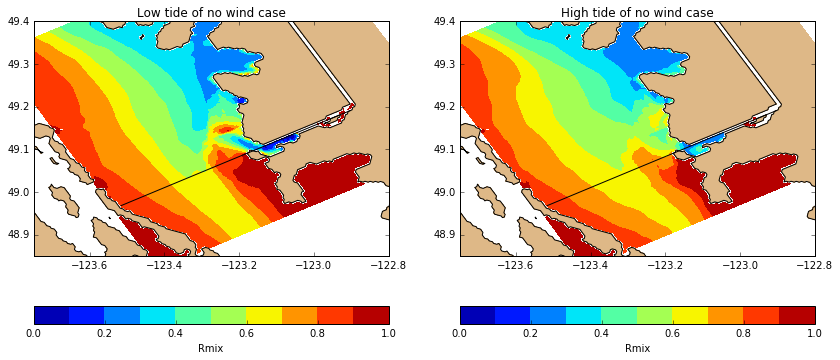

In [12]:
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,20,np_mask,title = ' no wind case',string = 'ave')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,20, np_mask,title = ' no wind case',string = 'ave')

# Combine all case

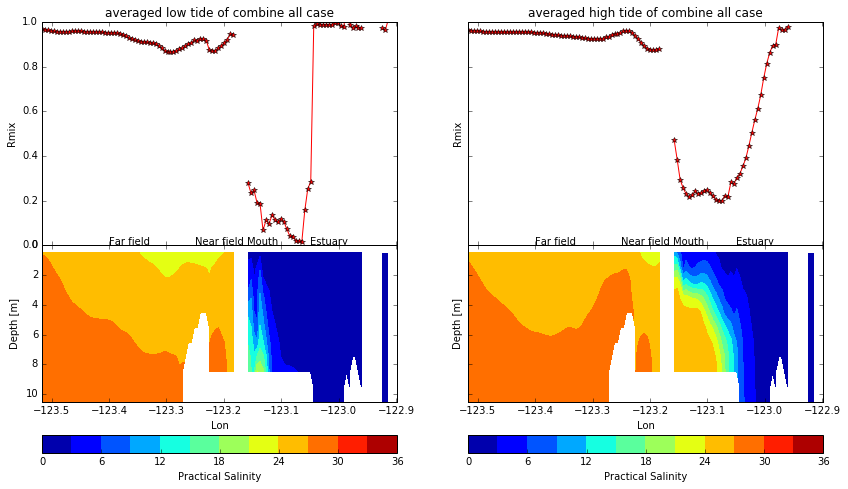

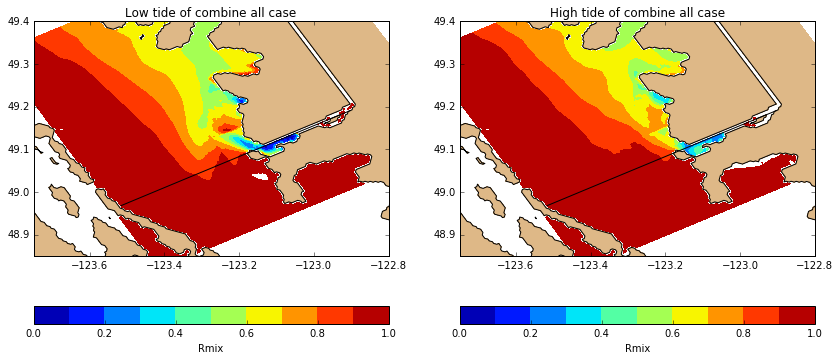

In [13]:
fig = RS.plot_salinity_estuary(all_T,sd,ed,10, np_mask,title = ' combine all case',string = 'ave')
fig = RS.plot_spatial_Rmix(all_T,sd,ed,10, np_mask,title = ' combine all case', string = 'ave')

# No tides case

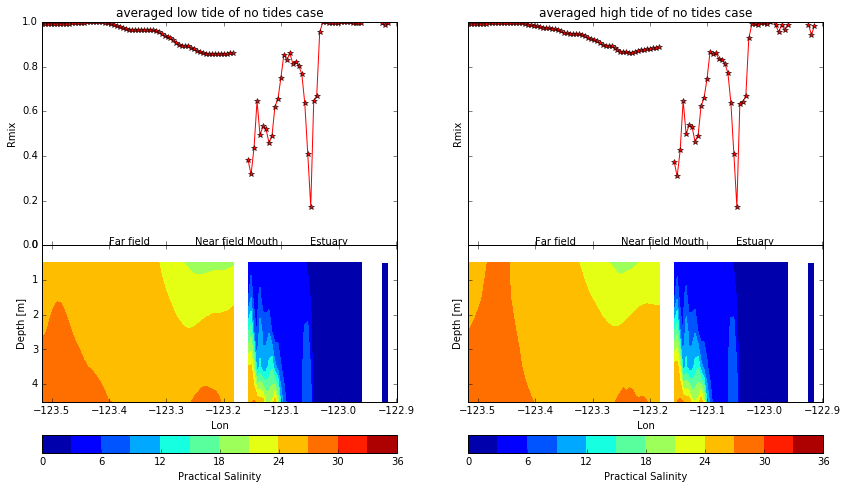

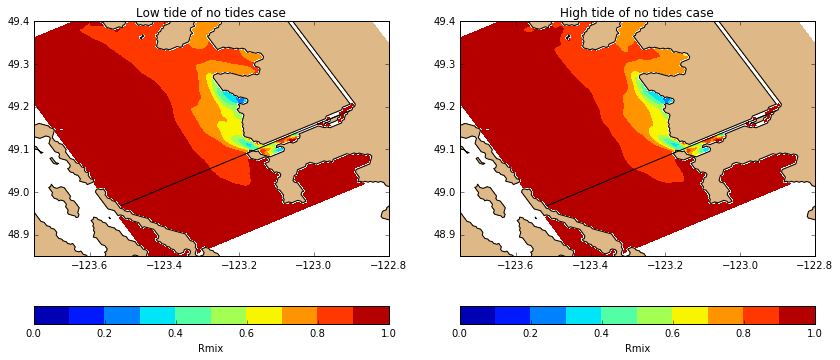

In [16]:
##averaged case
fig = RS.plot_salinity_estuary(notide_T,sd,ed,4, np_mask,title = ' no tides case',string = 'ave')
fig = RS.plot_spatial_Rmix(notide_T,sd,ed,4, np_mask,title = ' no tides case', string = 'ave')

# No f case

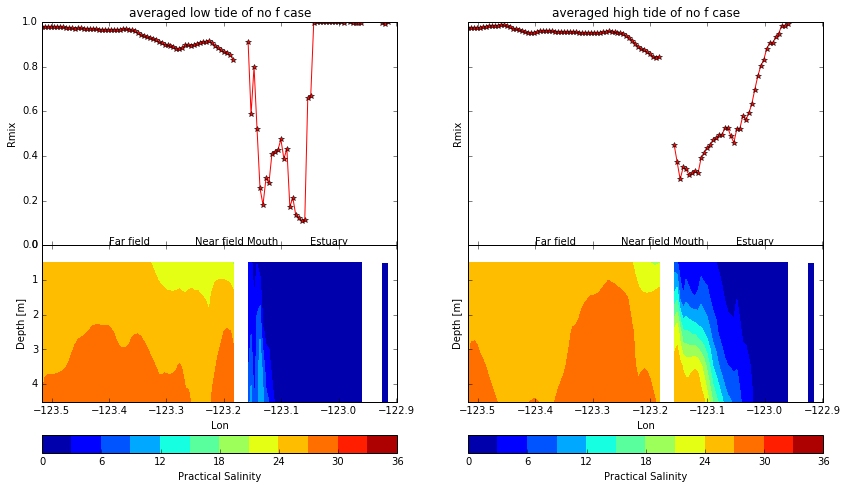

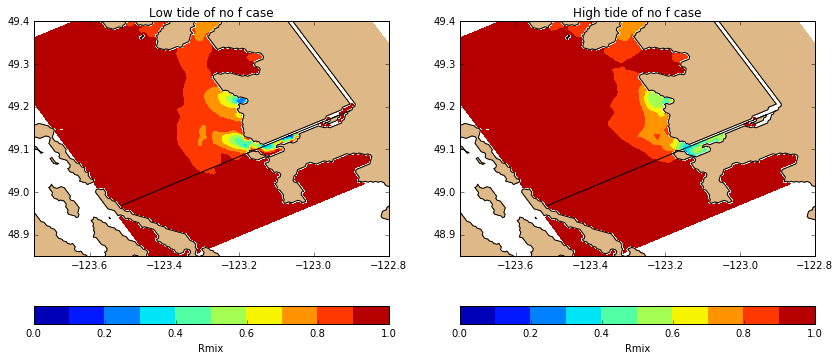

In [17]:
## averaged case
fig = RS.plot_salinity_estuary(nof_T,sd,ed,4, np_mask,title = ' no f case',string = 'ave')
fig = RS.plot_spatial_Rmix(nof_T,sd,ed,4, np_mask,title = ' no f case', string = 'ave')

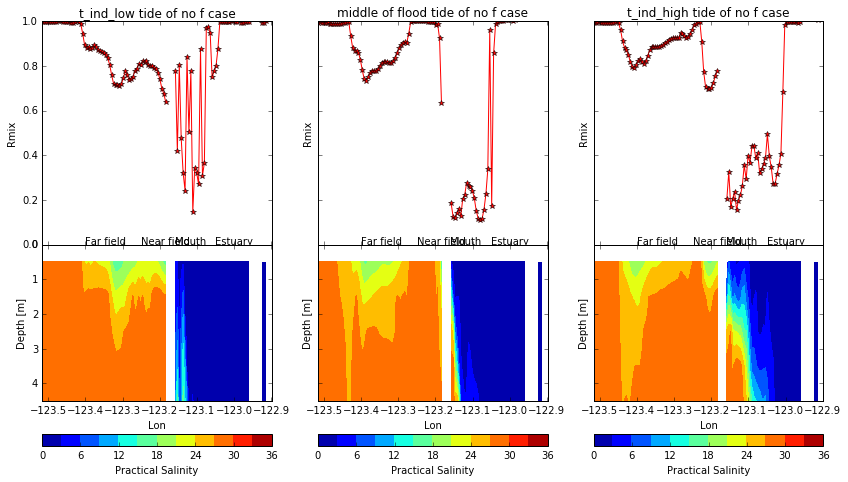

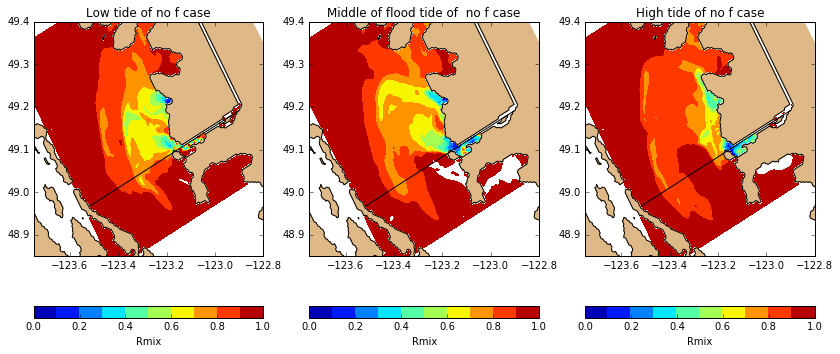

In [18]:
##specific time
fig= RS.plot_salinity_estuary(nof_T,sd,ed,4,np_mask,title = ' no f case')
fig = RS.plot_spatial_Rmix(nof_T,sd,ed,4, np_mask,title = ' no f case')

# Currents at those specific times

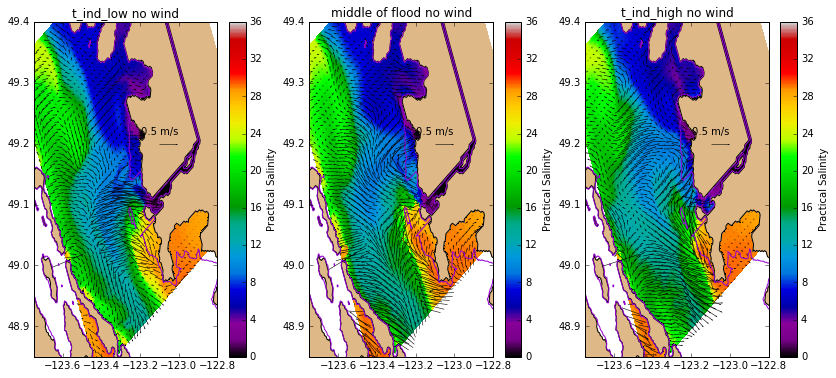

In [10]:
fig = RS.plot_spatial_circulation(nowind_T,nowind_U,nowind_V,0,'specific time',' no wind')

# Particle tracks of no wind case & combine all case

* At specific time

In [12]:
timesteps = all_T.variables['time_counter']
ssh = all_T.variables['sossheig']

In [13]:
par_nowind = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/specific_oct2014/\
/nowinds/ariane_trajectories_qualitative.nc')
par_all = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/specific_oct2014/\
/call/ariane_trajectories_qualitative.nc')

In [14]:
par_lon = {}; par_lat = {};
par_lon['nowind'] = par_nowind.variables['traj_lon']
par_lat['nowind'] = par_nowind.variables['traj_lat']
par_lon['all'] = par_all.variables['traj_lon']
par_lat['all'] = par_all.variables['traj_lat']

In [15]:
def plot_particle_track(lon,lat,part):
    """This function is made to plot the particle trajetories
    released within plume for each case"""
    colors=['g','Olive']
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    ax = axs[0] ## particle track
    viz_tools.plot_coastline(ax,grid6,coords='map')
    viz_tools.plot_coastline(ax,grid6,coords='map',isobath=4,color='violet')
    for i, key in enumerate(lon.keys()):
        ax.scatter(lon[key][1:10,part],lat[key][1:10,part],marker='o',color=colors[i],label=key)
        ax.scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    #ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='springgreen')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),ncol=5, fancybox=False, shadow=True)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    ax = axs[1] ## ssh plot
    ax.plot(timesteps[-24:],ssh[-24:,86,89],'k')
    ax.plot([timesteps[strings['specific time']['t_ind_low']],timesteps[strings['specific time']['t_ind_low']]],\
                   [-2.0,1.5],'b-',label='start')
    ax.plot([timesteps[strings['specific time']['t_ind_high']],timesteps[strings['specific time']['t_ind_high']]],\
                   [-2.0,1.5],'r-',label='end')
    ax.legend(loc = 'best')

    return fig      

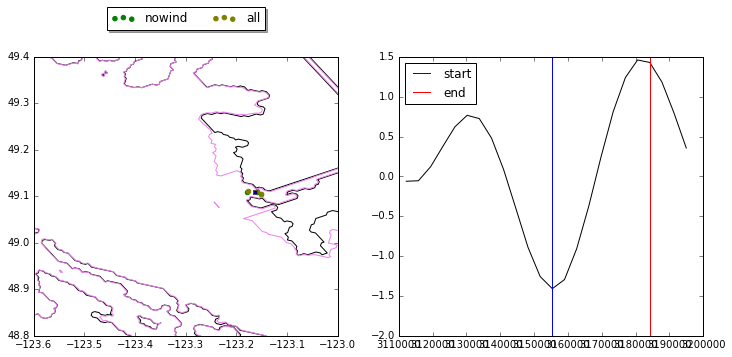

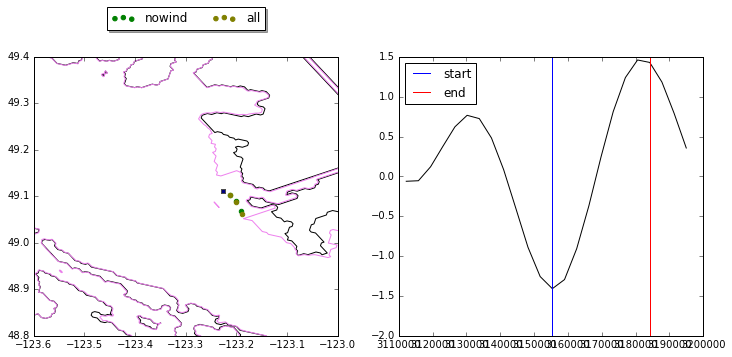

In [16]:
fig = plot_particle_track(par_lon,par_lat,0)
fig = plot_particle_track(par_lon,par_lat,1)

In [72]:
key1s = ['onlyriver','notides','nowinds','nof','all']
key2s = ['6hr','7hr','8hr']
lons = {};lats = {}
base='/ocean/jieliu/research/meopar/Ariane/result/specific_oct2014/blast/'
file_pattern = 'ariane_trajectories_qualitative.nc'
for k1 in key1s:
    lons[k1] = {}; 
    lats[k1] = {};
for k2 in key2s:
    for k1 in key1s:
        path = os.path.join(base,k1,k2,file_pattern)
        f = nc.Dataset(path,'r');
        lons[k1][k2] = f.variables['traj_lon']
        lats[k1][k2] = f.variables['traj_lat']

In [22]:
def plot_blast_tracks(lon,lat,sd,ed):
    """This function was made to plot all the tracks during flood tides in all run 
    cases, with two different released positions."""
    fig, axs = plt.subplots(2,3,figsize = (20,10))
    cs = ['orange','DodgerBlue','SeaGreen']
    key1s = ['onlyriver','notides','nowinds','nof','all']  
    for ax, key1 in zip([axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1]], key1s):
        key2s = ['6hr','7hr','8hr']
        for key2, c in zip (key2s, cs):
            for part in np.arange(lon[key1][key2].shape[1]):
                ax.scatter(lon[key1][key2][0,part],lat[key1][key2][0,part],color='0.50',marker='s',s=10)  
                ax.plot(lon[key1][key2][1:,part],lat[key1][key2][1:,part],color=c)
        ## fake the legend
        pa = 0
        key2s[0], = ax.plot(lon[key1][key2s[0]][1:,pa],lat[key1][key2s[0]][1:,pa],color=cs[0])
        key2s[1], = ax.plot(lon[key1][key2s[1]][1:,pa],lat[key1][key2s[1]][1:,pa],color=cs[1])
        key2s[2], = ax.plot(lon[key1][key2s[2]][1:,pa],lat[key1][key2s[2]][1:,pa],color=cs[2])
        ax.legend([key2s[0], key2s[1], key2s[2]], ['6hr', '7hr', '8hr'], loc='best')
        viz_tools.plot_coastline(ax,grid6,coords='map')
        viz_tools.plot_coastline(ax,grid6,coords='map',isobath=4,color='violet')
        ax.set_xlim([-123.6,-123]); ax.set_ylim([48.8,49.4])
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
        ax.set_title(key1)
    ## ssh 
    ax = axs[1,2]
    t_lims,t_highs,t_lows = RS.find_high_low_tide(sd,ed) ## get low, high tides time indices
    ax.plot(ttide.time[t_lims[0]+t_lows[5]:t_lims[0]+t_highs[5]],\
                 ttide.pred_all[t_lims[0]+t_lows[5]:t_lims[0]+t_highs[5]],color = cs[0],label = '6hr')
    ax.plot(ttide.time[t_lims[0]+t_lows[3]:t_lims[0]+t_highs[3]],\
                 ttide.pred_all[t_lims[0]+t_lows[3]:t_lims[0]+t_highs[3]],color = cs[1],label = '7hr')
    ax.plot(ttide.time[t_lims[0]+t_lows[0]:t_lims[0]+t_highs[0]],\
                 ttide.pred_all[t_lims[0]+t_lows[0]:t_lims[0]+t_highs[0]],color = cs[2],label = '8hr')
    ax.legend(loc='best')
    ax.plot(ttide.time[t_lims[0]+t_highs],ttide.pred_all[t_lims[0]+t_highs],'b*',markersize = 6)
    ax.plot(ttide.time[t_lims[0]+t_lows],ttide.pred_all[t_lims[0]+t_lows],'r.',markersize = 6)
    ax.set_xlim([datetime.datetime(2014,10,1),datetime.datetime(2014,11,1)])
    ax.set_xlabel('time'); ax.set_ylabel('observed ssh at PA [m]')
    ax.plot(ttide.time,ttide.pred_all,'k')
    for i in np.arange(31): ## for october
        if i ==5:
            ax.plot(ttide.time[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],\
                 ttide.pred_all[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],color = cs[0])
        if ((i>=3) & (i<=4)) | ((i>=9) & (i<=11)) | ((i>=16) & (i<=18)) | ((i>=23) & (i<=28)) | (i ==30):
            ax.plot(ttide.time[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],\
                 ttide.pred_all[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],color = cs[1])
        if ((i>=0) & (i<=2)) | ((i>=12) & (i<=15)) | (i==29):
            ax.plot(ttide.time[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],\
                 ttide.pred_all[t_lims[0]+t_lows[i]:t_lims[0]+t_highs[i]],color = cs[2])
    return fig

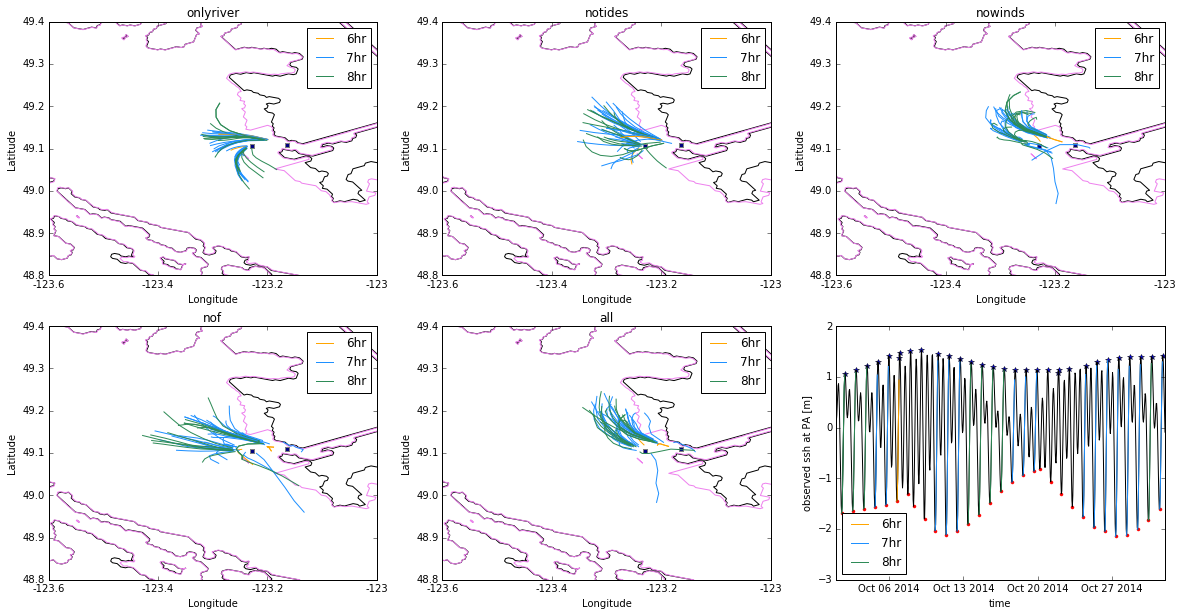

In [23]:
fig = plot_blast_tracks(lons,lats,sd,ed)

# U, V at river mouth of a specific tidal cycle

In [11]:
sites = {
    'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{'lat': 49.0419, 'lon': -123.3176,'depth': 170, 'j': 36, 'i': 43},    
    'VENUS Central':{ 'lat': 49.0401,'lon': -123.4261, 'depth': 300, 'j': 44, 'i': 26 },
    'Point on transect':{'j':36,'i':20},
    'mouth':{ 'j':38,'i':73},
    'near field':{'j':43,'i':64},
    'middle':{'j':40,'i':70},
    'north':{'j':46,'i':70},
    'north_more':{'j': 49,'i':73},
    'estuary':{'j':36,'i':102},
    'pp_along':{'j':55,'i':71},
    }


In [21]:
def plot_salinity_alongtransect(grid_T,dep_ind,along = True,title = ' no wind',smin = 0, smax = 36):
    """This function was made to plot the salinity
        along the north transect"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    dep = grid_T.variables['deptht']
    f, axs = plt.subplots(1, 4,figsize = (24,5))
    if along == True:
        jss = np.arange(40,55)
        iss = 71
        X = lat[jss,iss]
        for ax in axs[:-1]:
            ax.set_xlim([lat[jss[0],iss],lat[jss[-1],iss]])
            ax.set_xlabel('Lat')
    else:
        jss = 47
        iss = np.arange(57,71)
        X = lon[jss,iss]
        for ax in axs[:-1]:
            ax.set_xlim([lon[jss,iss[0]],lon[jss,iss[-1]]])
            ax.set_xlabel('Lon')
    S_stn = S[:,:,jss,iss]
    cmap = plt.get_cmap('jet')

    ## tmask
    mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
    tmask = mesh.variables['tmask'][:,:,jss+380,iss+240]
    np_mask = np.abs(1-tmask) 
       
    for ax ,st in zip(axs[:-1], [-7,-5,-4]):
        np_mask=np_mask +np.zeros(S_stn.shape) 
        S_else = np.ma.masked_array(S_stn,mask=np_mask) ## mask sal=0 by tmask
        mesh = ax.contourf(X, dep[:], S_else[st],np.arange(smin,smax+3,3),cmap = cmap)     
        cbar=f.colorbar(mesh,ax = ax,orientation ='horizontal')
        cbar.set_label('Practical Salinity')
        
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([dep[dep_ind],0])
        ax.set_title(st)
    ax = axs[-1]
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.plot(lon[jss,iss],lat[jss,iss],'b-')
    ax.set_xlim([-123.6,-122.9])
    ax.set_ylim([48.95,49.4])
    

In [13]:
def test_uvS(grid_T,grid_U,grid_V,dep_ind0,dep_ind1,start,end,site,ylim = 1.5,smin = 0, smax = 30):
    
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(3, 2,width_ratios=[1,3], height_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.15)
    dep = grid_T.variables['deptht']
    t = grid_T.variables['time_counter']
    ssh = grid_T.variables['sossheig']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S = grid_T.variables['vosaline']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    
    UU,VV = viz_tools.unstagger(U[start:end+1,dep_ind0,sites[site]['j']:sites[site]['j']+2,\
                                  sites[site]['i']:sites[site]['i']+2],\
                                V[start:end+1,dep_ind0,sites[site]['j']:sites[site]['j']+2,\
                                  sites[site]['i']:sites[site]['i']+2])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)
    
    ax = fig.add_subplot(gs[0,0])
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.plot(lon[sites[site]['j'],sites[site]['i']],lat[sites[site]['j'],sites[site]['i']],'r*')
    ax.set_xlim([-123.6,-122.9])
    ax.set_ylim([48.95,49.4])
    plt.grid('on')
    #U time series
    ax = fig.add_subplot(gs[0,1])
    ax.plot(t[start:end+1], UU[(start-end+1):,0,0],'b-*',label = 'u')
    ax.plot(t[start:end+1], VV[(start-end+1):,0,0],'r-*',label = 'v')
    plt.grid('on')
    ax.set_ylim([-ylim,ylim])
    ax.set_ylabel('velocity, m/s')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(gs[1,1])
    S_stn = S[:,:,sites[site]['j'],sites[site]['i']]
    ## tmask
    mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
    tmask = mesh.variables['tmask'][0,:,sites[site]['j']+380,sites[site]['i']+240]
    np_mask = np.abs(1-tmask) 
    np_mask=np_mask +np.zeros(S_stn.shape) 
    S_stn = np.ma.masked_array(S_stn,mask=np_mask) ## mask sal=0 by tmask
    time_inds = np.arange(S_stn.shape[0]) ## Define time
    mesh = ax.contourf(time_inds, dep[:],np.transpose(S_stn[:]),np.arange(smin, smax+3, 3),cmap = 'jet')
    cbar=fig.colorbar(mesh,ax = ax,orientation="horizontal")
    cbar.set_label('Practical Salinity')
    ax.set_ylim([dep[dep_ind1], dep[0]])
    ax.set_xlim(time_inds[start],time_inds[end])
    ax = fig.add_subplot(gs[2,1])
    ax.plot(t[start:end+1],ssh[start:end+1,sites[site]['j'],sites[site]['i']],\
                'y-*',label = 'modeled ssh at '+site) ## modelled ssh at the site
    ax.set_ylabel('ssh, m')
    plt.grid('on')    

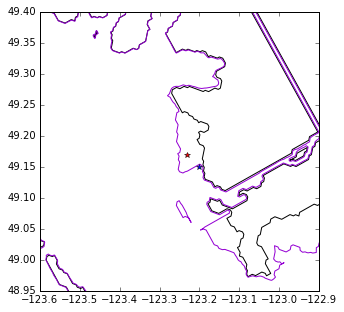

In [77]:
fig,ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.set_xlim([-123.6,-122.9])
ax.set_ylim([48.95,49.4])
ax.plot(lon[sites['north_more']['j'],sites['north_more']['i']], \
        lat[sites['north_more']['j'],sites['north_more']['i']],'b*')
ax.plot(lon[55,71], \
        lat[55,71],'r*')

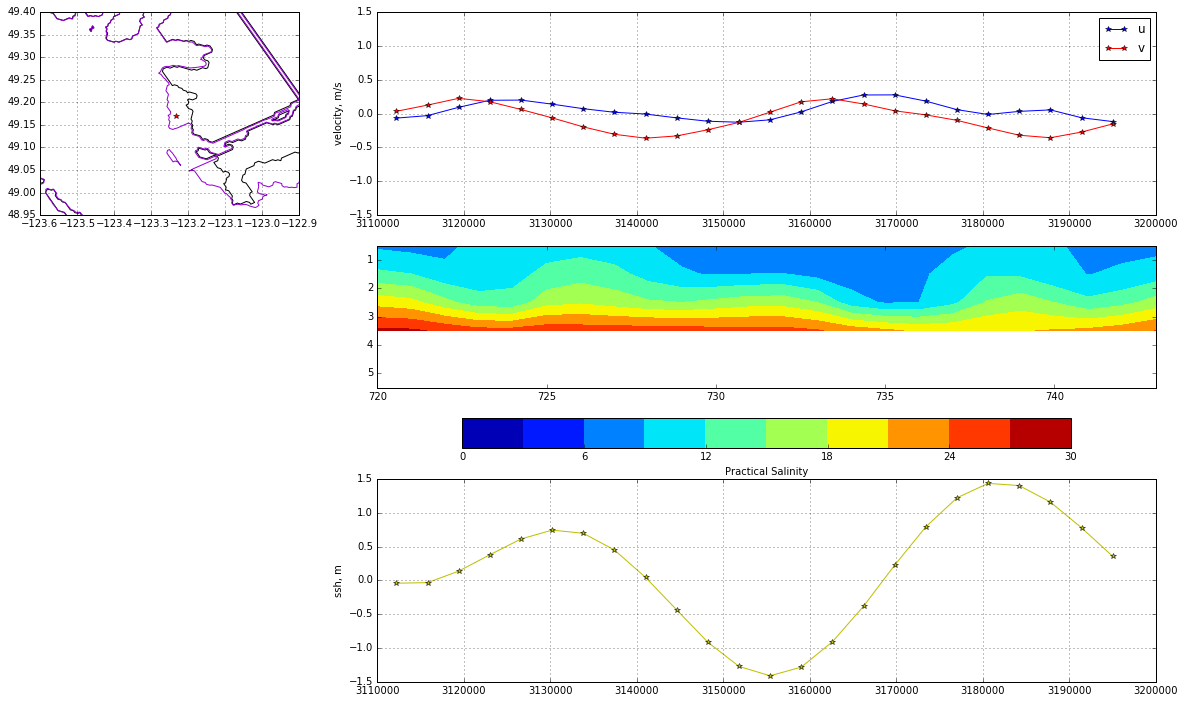

In [14]:
test_uvS(nowind_T,nowind_U,nowind_V,0,5,-24,743,'pp_along')

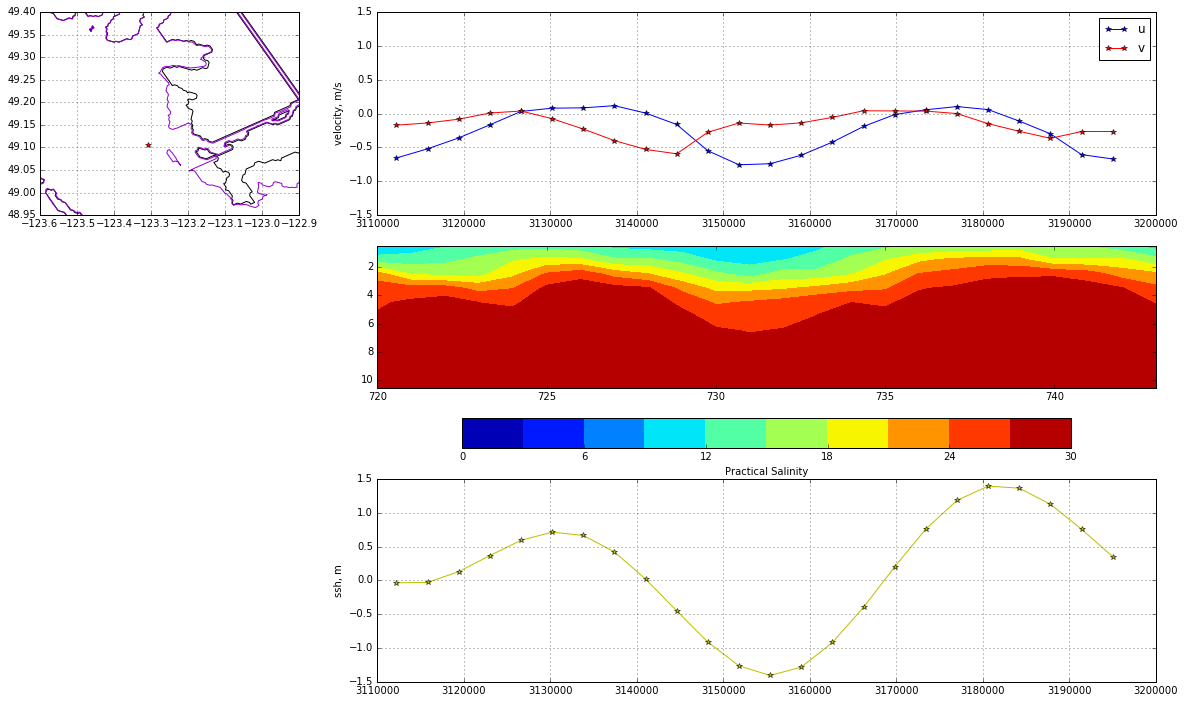

In [15]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'Steveston')

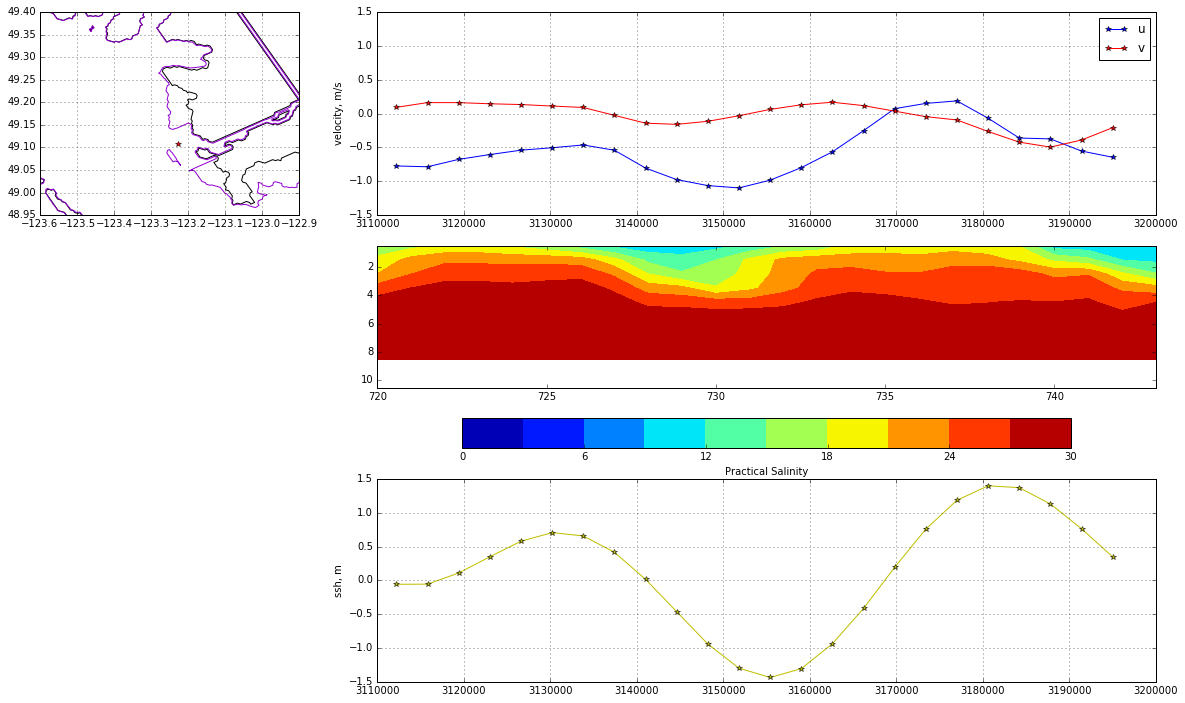

In [16]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'near field')

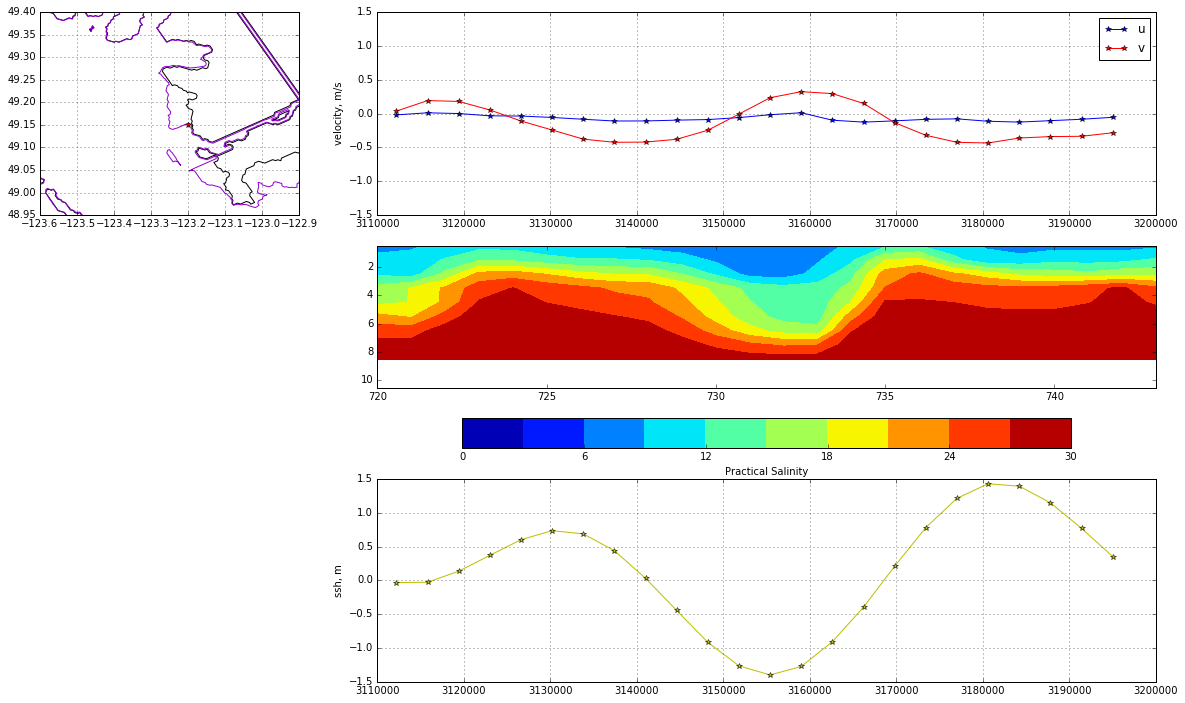

In [17]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'north_more')

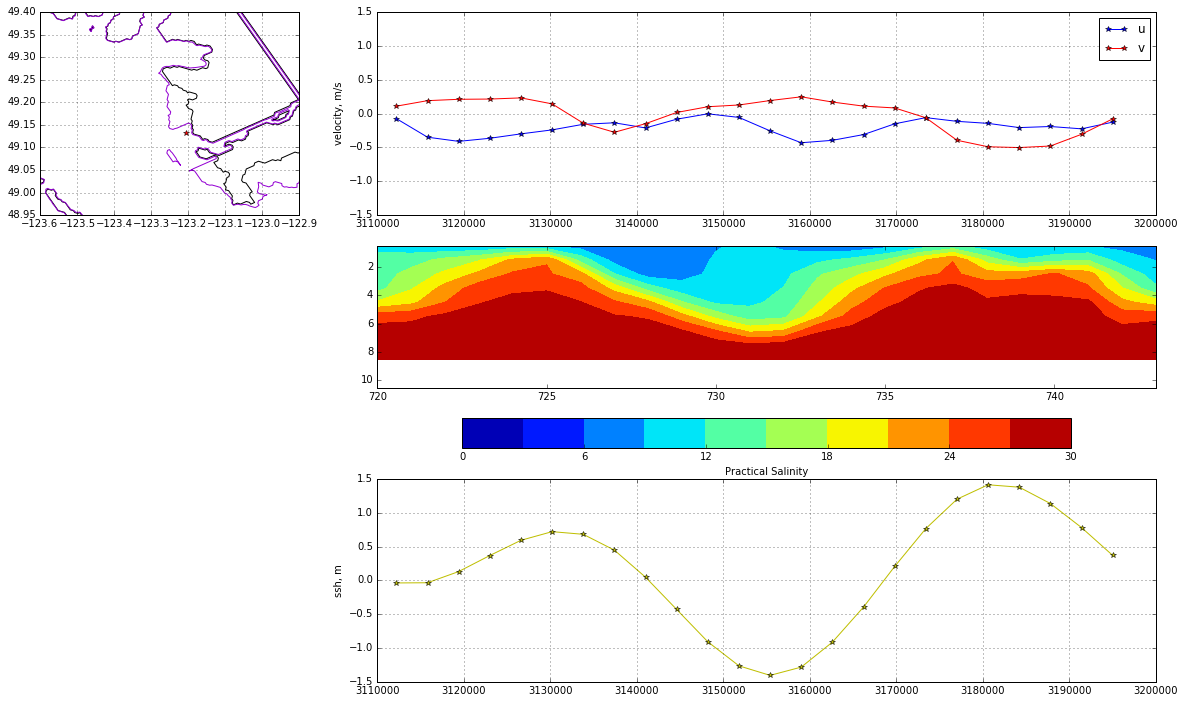

In [18]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'north')

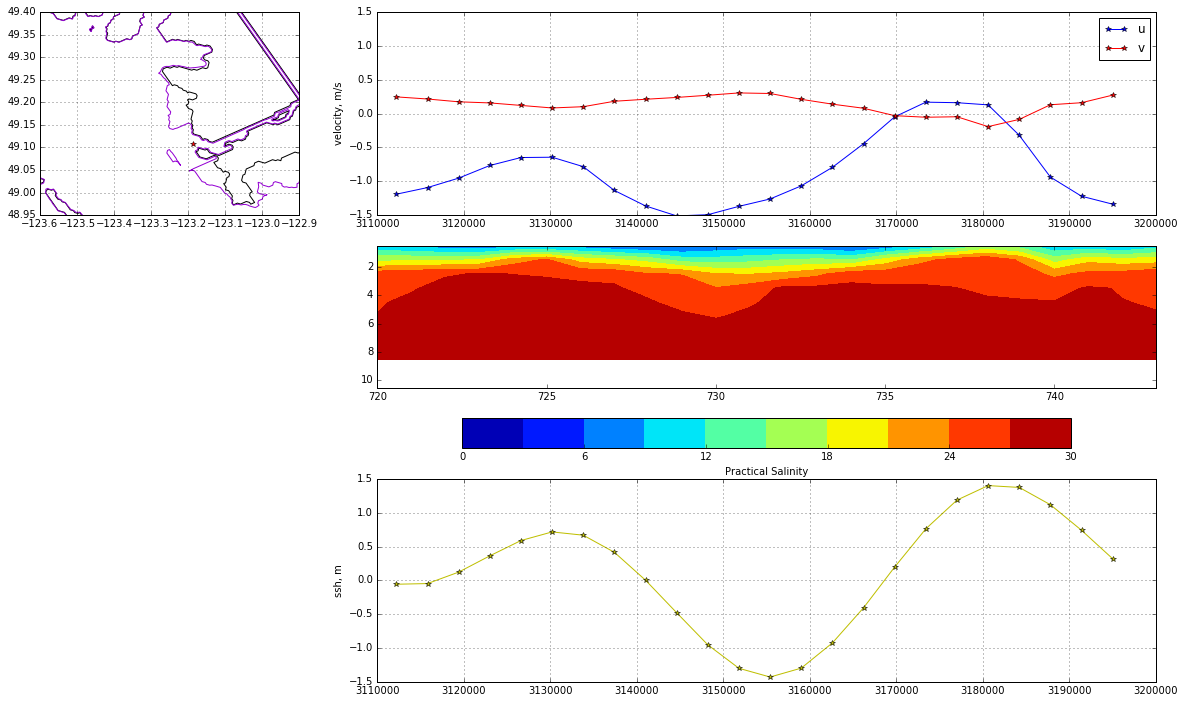

In [19]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'middle')

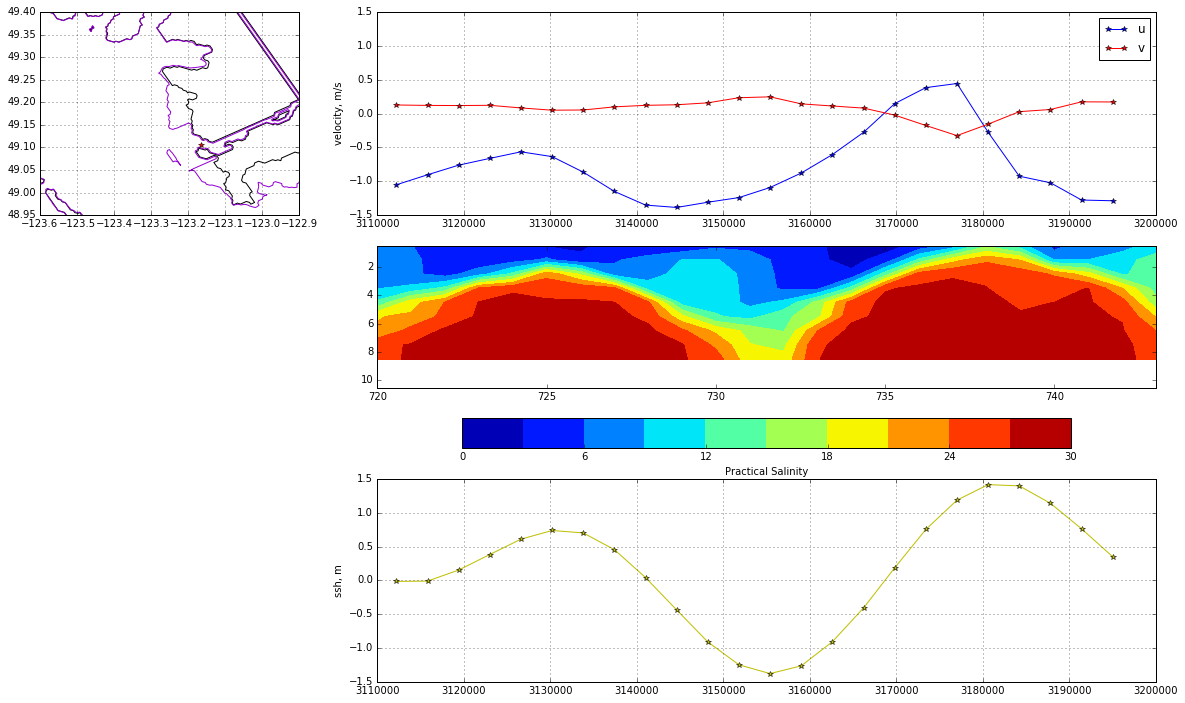

In [20]:
test_uvS(nowind_T,nowind_U,nowind_V,0,10,-24,743,'mouth')

* Nearly no flood tide for position northward off the river mouth, where the u is always negative.

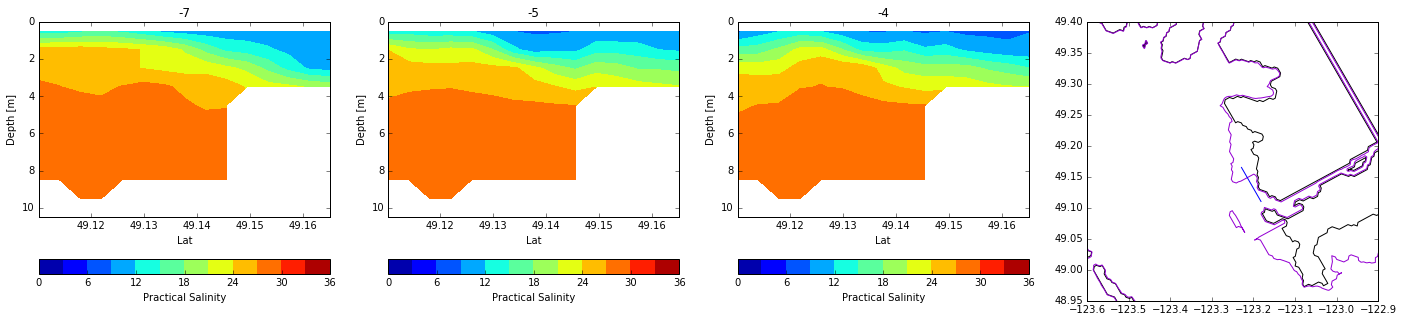

In [22]:
## salinity cross north transect during flood tide 
plot_salinity_alongtransect(nowind_T,10)

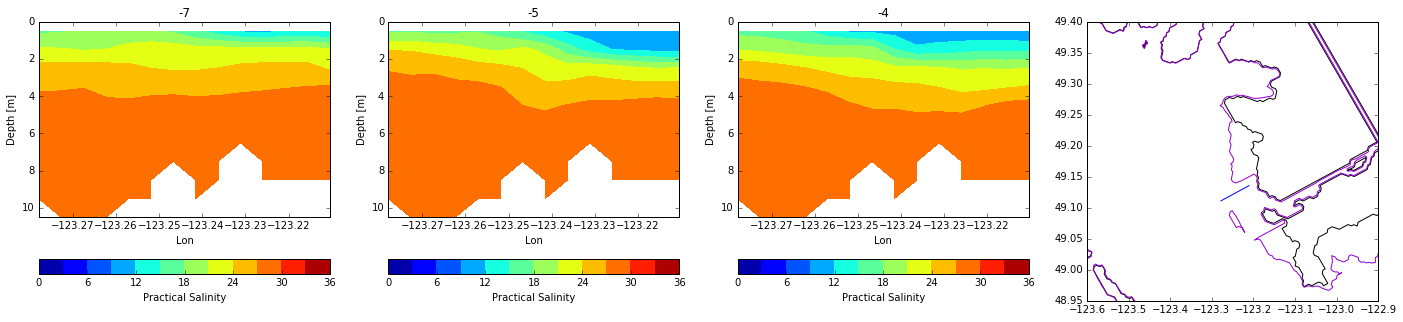

In [23]:
## salinity along north transect during flood tide 
plot_salinity_alongtransect(nowind_T,10,along = False)

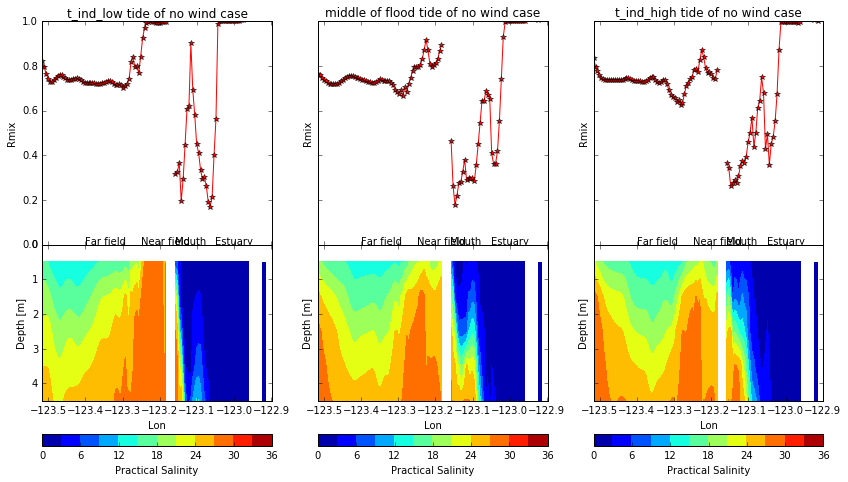

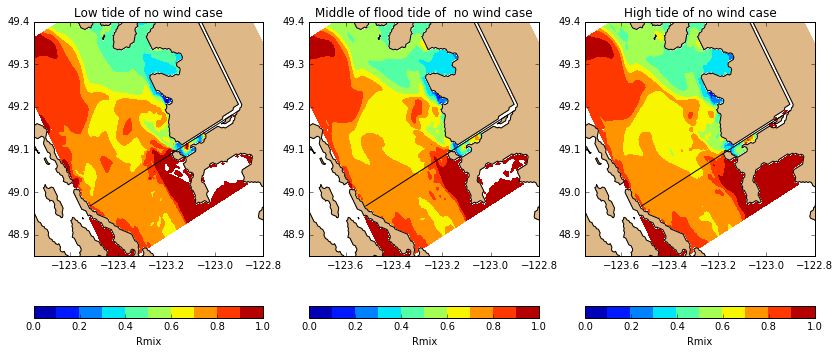

In [11]:
## correct the low/high tide threshold with currents in the mouth region as a measurement 
## instead of ssh at specific point
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case', string = 'current time')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case', string = 'current time')

* Zoom in mouth region, from left to right, are the start of the flood tide (u turn to positive,v turn to negative ), middle of the flood tide and end of the flood tide (u turn to negative, v turn to positive).

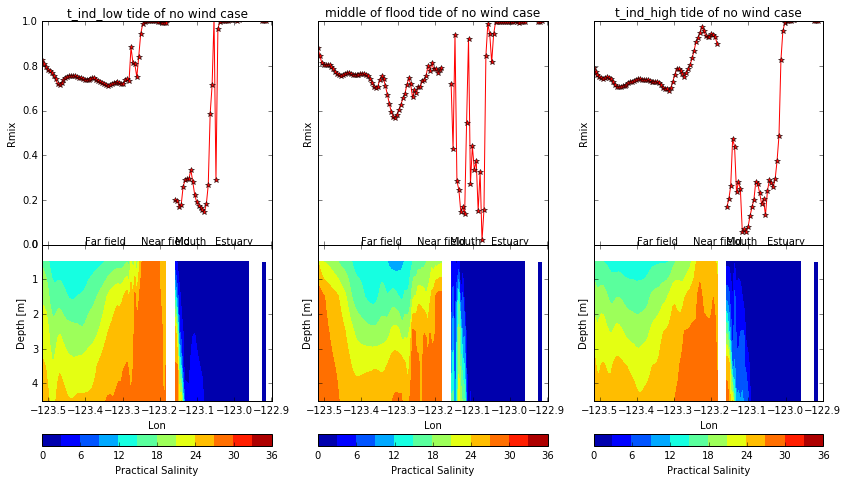

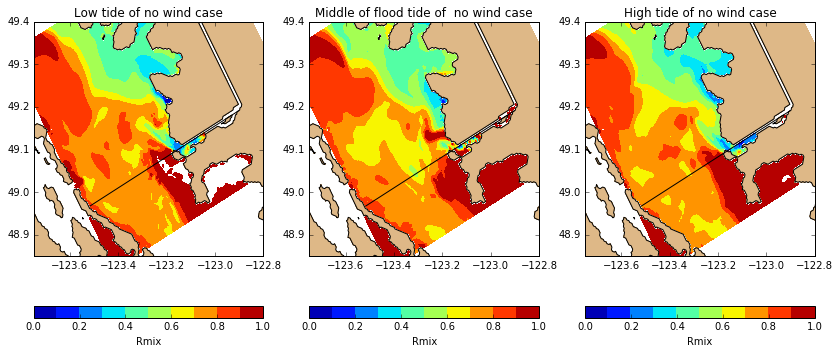

In [11]:
## this is during ebb tide, look at it from right to left
fig= RS.plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case', string = 'current time')
fig = RS.plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case', string = 'current time')

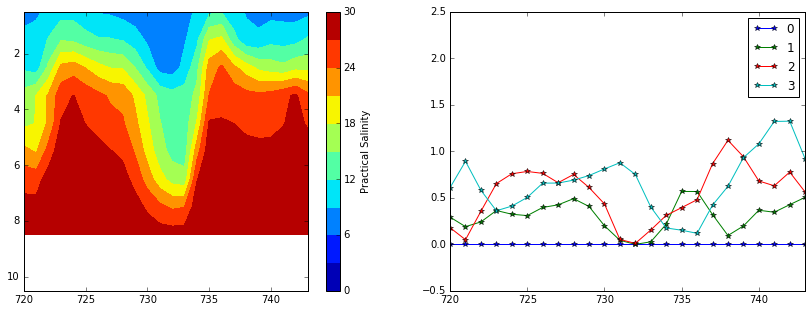

In [80]:
## look at salinity time series at north more point
fig,axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
smin = 0;smax = 30; stn = 'north_more'; dep_ind = 10;
dep_T = nowind_T.variables['deptht']
S = nowind_T.variables['vosaline']
S_stn = S[:,:,sites[stn]['j'],sites[stn]['i']]
 ## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,sites[stn]['j']+380,sites[stn]['i']+240]
np_mask = np.abs(1-tmask) 
np_mask=np_mask +np.zeros(S_stn.shape) 
S_stn = np.ma.masked_array(S_stn,mask=np_mask) ## mask sal=0 by tmask
time_inds = np.arange(S_stn.shape[0]) ## Define time
mesh = ax.contourf(time_inds, dep_T[:],np.transpose(S_stn[:]),np.arange(smin, smax+3, 3),cmap = 'jet')
cbar=fig.colorbar(mesh,ax = ax)
cbar.set_label('Practical Salinity')
ax.set_ylim([dep_T[dep_ind], dep_T[0]])
ax.set_xlim(time_inds[-24],time_inds[-1])

## calculate square of buoyancy frequency based on salinity
ax = axs[1]
deriS = np.zeros(S_stn.shape)
for i in np.arange(1,S_stn.shape[1]):
    deriS[:, i] = 1/S_stn[:,0] *(S_stn[:,i] - S_stn[:,i-1])
for i in np.arange(4):
    plt.plot(time_inds, deriS[:,i],'-*',label = i)
    plt.xlim([time_inds[-24],time_inds[-1]])
    plt.legend()